❓ Hypothesis: Does the discount on the items cause a noticeable change in the number of sales or not?

Importing libraries 📚

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import mysql.connector
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

Connecting to DataBase 🧮

In [23]:
my_database = mysql.connector.connect(
  host = "127.0.0.1",
  port = "3306",
  user = "root",
  password = "pass",
  auth_plugin = "mysql_native_password",
  database = "superstore"
)

Get the DataFrame ready 📋

In [24]:
cursor = my_database.cursor()

query = """
SELECT product.`Product ID`, `Order ID`, Quantity, Discount FROM product 
JOIN order_detail ON product.`Product ID` = order_detail.`Product ID`
"""

cursor.execute(query)
rows = cursor.fetchall()
column_names = [column[0] for column in cursor.description]

products = pd.DataFrame(rows, columns = column_names)

cursor.close()
my_database.close()
products.head()

,Product ID,Order ID,Quantity,Discount
0,FUR-ADV-10000002,IZ-2014-4660,1,0.0
1,FUR-ADV-10000108,MO-2012-8110,1,0.0
2,FUR-ADV-10000108,RW-2012-8200,4,0.0
3,FUR-ADV-10000108,LI-2011-9980,2,0.0
4,FUR-ADV-10000183,TU-2014-4400,4,0.6


In [25]:
products["hasDiscount"] = np.where(products["Discount"] == 0, False, True)
products.head(3)

,Product ID,Order ID,Quantity,Discount,hasDiscount
0,FUR-ADV-10000002,IZ-2014-4660,1,0.0,False
1,FUR-ADV-10000108,MO-2012-8110,1,0.0,False
2,FUR-ADV-10000108,RW-2012-8200,4,0.0,False


In [26]:
products = pd.DataFrame(products.groupby(["Product ID", "hasDiscount"])["Quantity"].sum())
products = products.unstack(level = "hasDiscount")
products = products.fillna(0)
products = products.stack(level = "hasDiscount")
products = products.reset_index()
products.head()

,Product ID,hasDiscount,Quantity
0,FUR-ADV-10000002,False,1.0
1,FUR-ADV-10000002,True,0.0
2,FUR-ADV-10000108,False,7.0
3,FUR-ADV-10000108,True,0.0
4,FUR-ADV-10000183,False,11.0


Effects of Discount on Quantity of Products which were sold both with and without Discount 📈

In [27]:
products = products.drop(products[products["Quantity"] == 0].index)
products = products.groupby("Product ID").filter(lambda x : x["hasDiscount"].nunique() > 1)
products.head(4)

,Product ID,hasDiscount,Quantity
4,FUR-ADV-10000183,False,11.0
5,FUR-ADV-10000183,True,20.0
6,FUR-ADV-10000188,False,4.0
7,FUR-ADV-10000188,True,3.0


In [28]:
ttest_ind(products[products["hasDiscount"] == True]["Quantity"], products[products["hasDiscount"] == False]["Quantity"])

Ttest_indResult(statistic=-12.249599064346258, pvalue=2.603040618920372e-34)

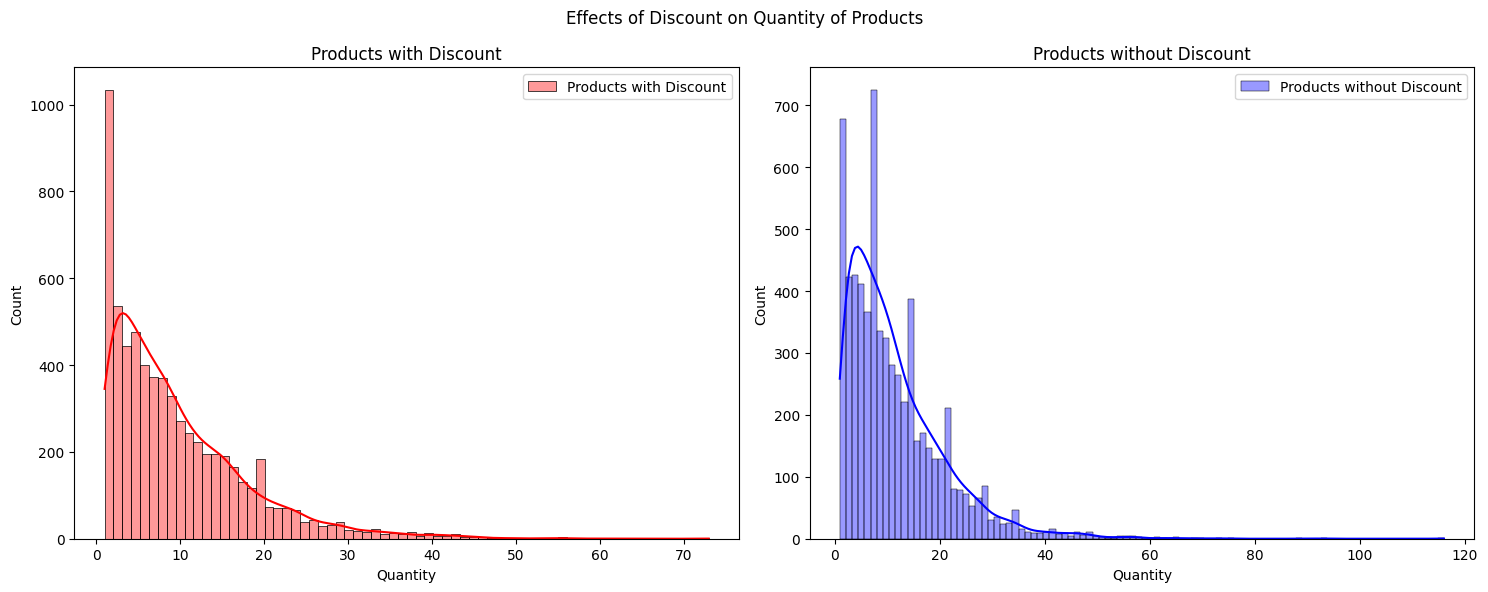

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
sns.histplot(products[products["hasDiscount"] == True]["Quantity"], kde = True, color = "red", alpha = 0.4, label = "Products with Discount", ax = axes[0])
axes[0].set_title("Products with Discount")

sns.histplot(products[products["hasDiscount"] == False]["Quantity"], kde = True, color = "blue", alpha = 0.4, label = "Products without Discount", ax = axes[1])
axes[1].set_title("Products without Discount")

fig.suptitle("Effects of Discount on Quantity of Products")
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

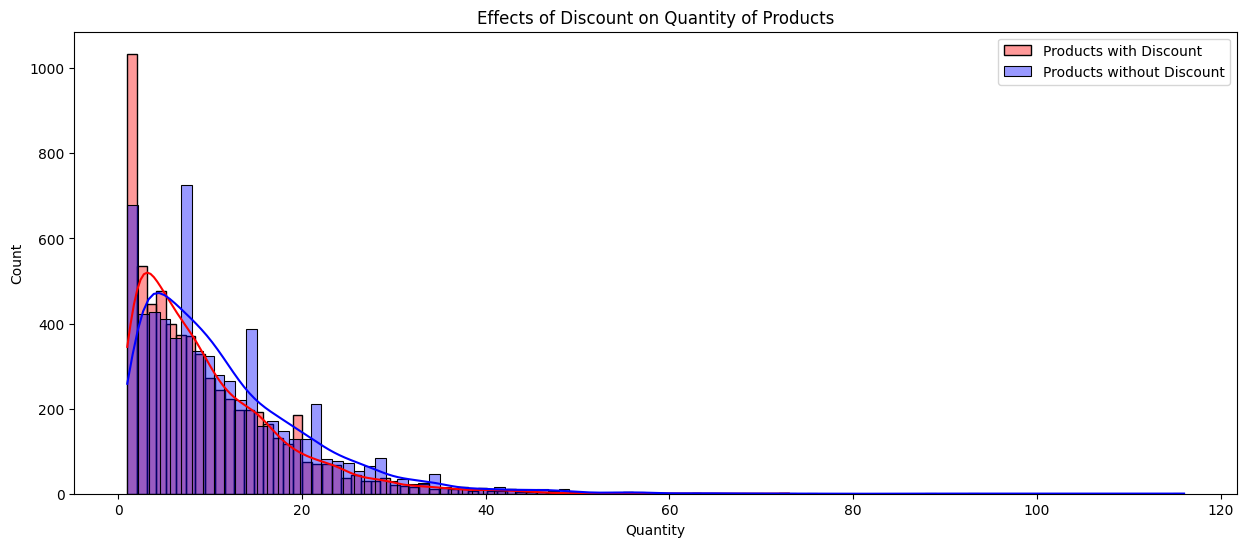

In [30]:
plt.figure(figsize = (15, 6))
sns.histplot(products[products["hasDiscount"] == True]["Quantity"], kde = True, color = "red", alpha = 0.4, label = "Products with Discount")
sns.histplot(products[products["hasDiscount"] == False]["Quantity"], kde = True, color = "blue", alpha = 0.4, label = "Products without Discount")
plt.legend()
plt.title("Effects of Discount on Quantity of Products")
plt.show()

In [31]:
mean_quantity = products.groupby("hasDiscount")["Quantity"].mean()
mean_quantity

hasDiscount
False    11.616549
True      9.724533
Name: Quantity, dtype: float64